In [1]:
%matplotlib inline
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from tools.common import disp_grid
from IPython.display import Image
from skimage.io import imsave

from keras.models import model_from_json
import os
import joblib
import numpy as np
from lightjob.cli import load_db
#from skimage.io import imread
from tools.common import find_generation_job, find_training_job

from lightjob.cli import load_db
import pandas as pd

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [79]:
db = load_db()
jobs = db.jobs_with(state='success', where='jobset76')
S = [j['summary'] for j in jobs]
stats = {s: pd.read_csv('../jobs/results/{}/csv/stats.csv'.format(s)) for s in S}

In [81]:
job_id = '4d8d586688c602b07cd4ab46f1081295'
job = db.get_job_by_summary(job_id)
folder = '../jobs/results/{}'.format(job_id)
data = joblib.load(os.path.join(folder, 'images.npz'))
data = data[:, -1] # last time step images
model_folder = '../tools/models/mnist/m2'
model = model_from_json(open(os.path.join(model_folder, 'model.json')).read())
model.load_weights(os.path.join(model_folder, 'model.h5'))

In [83]:
preds = model.predict(data)

In [82]:
CLASS = 1

In [84]:
#img = data[ind]
img = data
#print(img.shape)
img = disp_grid(img, border=1, bordercolor=(0.3, 0, 0))

In [85]:
bins = np.linspace(0, 1, 11)
bin_index = np.digitize(preds[:, CLASS], bins)

In [86]:
w = data.shape[3] * (len(bins)-1)
h = data.shape[2] * (len(bins)*100)
IMG = np.ones((h, w))*0.5
for i in range(1, len(bins)):
    d = data[bin_index==i]
    p = preds[bin_index==i, CLASS]
    s = np.argsort(p)
    p = p[s]
    p = p[::-1]
    d = d[s]
    d = d[::-1]
    x = (i-1) * data.shape[3]
    y=0
    for im in d:
        IMG[y:y+data.shape[2], x:x+data.shape[3]] = im[0, :, :]
        y+=d.shape[2]
    IMG[:, (i-1) * data.shape[3]]=0.3
    for y in range(len(d)):
        IMG[y*d.shape[2], :]=0.3

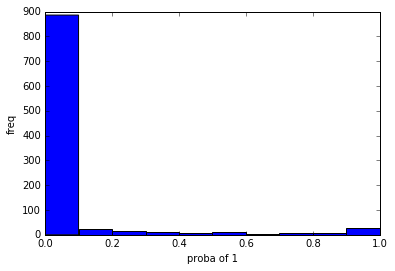

In [87]:
plt.hist(preds[:, CLASS])
plt.xlabel('proba of {}'.format(CLASS))
plt.ylabel('freq')

In [88]:
job['stats']['out_of_the_box_classification']['tools/models/mnist/m2']['objectness']

KeyError: 'out_of_the_box_classification'

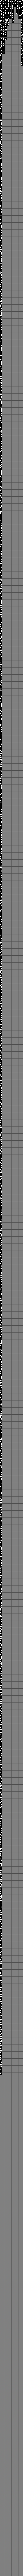

In [89]:
imsave('out.png',IMG)
Image('out.png')

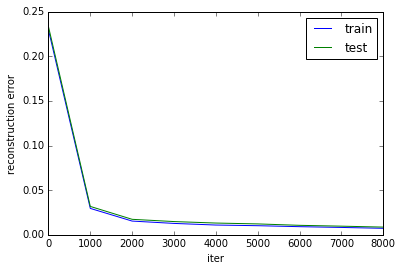

In [92]:
plt.plot((stats[find_training_job(job_id)['summary']]['train_recons_error'] / (28*28.)).dropna(), label='train')
plt.plot((stats[find_training_job(job_id)['summary']]['test_recons_error'] / (28*28.)).dropna(), label='test')
plt.xlabel('iter')
plt.legend()
plt.ylabel('reconstruction error')